[*********************100%***********************]  1 of 1 completed


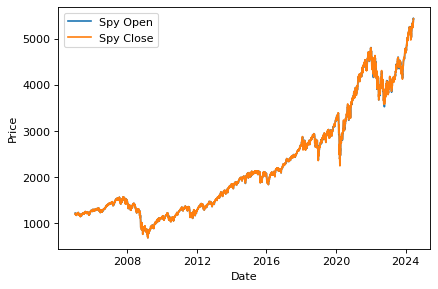

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import datetime as dt
import yfinance as yf
import ffn

# Set display options for pandas
pd.set_option("max_colwidth", 100)
pd.set_option("display.max_rows", 100000)
pd.set_option("display.max_columns", 1000)

# Fetch data from Yahoo Finance
ticker = '^SPX'
data = yf.download(ticker, start="2005-01-01", end="2024-06-15")
data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
data['Adj_Open'] = data['Open'] * (data['Adj_Close'] / data['Close'])

# Select the required columns
pricing = data[['Adj_Open', 'Adj_Close']].reset_index()

# Plot the data
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pricing['Date'], pricing['Adj_Open'], label='Spy Open')
plt.plot(pricing['Date'], pricing['Adj_Close'], label='Spy Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [2]:
pricing.head()

,Date,Adj_Open,Adj_Close
0,2005-01-03,1211.920044,1202.079956
1,2005-01-04,1202.079956,1188.050049
2,2005-01-05,1188.050049,1183.739990
3,2005-01-06,1183.739990,1187.890015
4,2005-01-07,1187.890015,1186.189941


In [3]:
# Shift adjusted close for trading strategy
stock = pricing.copy()
stock['Adj_Close'] = stock['Adj_Close'].shift(1)
stock.tail()

,Date,Adj_Open,Adj_Close
4891,2024-06-10,5341.220215,5346.990234
4892,2024-06-11,5353.000000,5360.790039
4893,2024-06-12,5409.129883,5375.319824
4894,2024-06-13,5441.930176,5421.029785
4895,2024-06-14,5424.080078,5433.740234


In [4]:
# Split data into chunks
stock_1 = stock.iloc[0:2170].copy()
stock_2 = stock.iloc[2170:4342].copy().reset_index(drop=True)
stock_3 = stock.iloc[4342:6513].copy().reset_index(drop=True)
stock_2.head()

,Date,Adj_Open,Adj_Close
0,2013-08-16,1661.219971,1661.319946
1,2013-08-19,1655.250000,1655.829956
2,2013-08-20,1646.810059,1646.060059
3,2013-08-21,1650.660034,1652.349976
4,2013-08-22,1645.030029,1642.800049


In [5]:
# Define trading strategy
def trade(stock, length):
    temp_dict = {}
    if length == 0:
        return 0

    rolling_window = stock['Adj_Close'].rolling(window=length)
    mu = rolling_window.mean()
    std = rolling_window.std()

    max_position = 1
    slippage_adj = 0.99

    zscores = (stock['Adj_Close'] - mu) / std

    money = 30
    position_count = 0

    for i, row in stock.iterrows():
        if zscores[i] > 1 and position_count < max_position:
            money -= stock['Adj_Open'][i] * (1 / slippage_adj)
            position_count += 1
        elif zscores[i] < -1 and position_count > max_position * -1:
            money += stock['Adj_Open'][i] * slippage_adj
            position_count -= 1
        elif abs(zscores[i]) < 0.5:
            if position_count > 0:
                money += position_count * stock['Adj_Open'][i] * slippage_adj
            elif position_count < 0:
                money += position_count * stock['Adj_Open'][i] * (1 / slippage_adj)
            position_count = 0
        
        temp_dict[stock['Date'][i]] = [
            stock['Adj_Open'][i], stock['Adj_Close'][i], mu[i], std[i], zscores[i],
            money, position_count, stock['Adj_Open'][i] * (1 / slippage_adj), stock['Adj_Open'][i] * slippage_adj
        ]

    pr = pd.DataFrame(data=temp_dict).T
    pr.index.name = 'Date'
    pr.index = pd.to_datetime(pr.index)
    pr.columns = [
        'Open', 'Close', 'mu', 'std', 'zscores', 'money', 'position_count', 'buy_slippage', 'sell_slippage'
    ]
    pr['equity'] = pr['money'] + (pr['Open'] * pr['position_count'])
    return pr


In [6]:
# Apply the trading strategy
moving_average = 200
profit = trade(pricing, moving_average)

# Analyze the profit
series = profit[['equity']].copy()
series = series[moving_average:-1]

stats = series.calc_stats()
stats.display()

Stat                 equity
-------------------  ----------
Start                2005-10-18
End                  2024-06-13
Risk-free rate       0.00%

Total Return         9938.90%
Daily Sharpe         0.72
Daily Sortino        1.20
CAGR                 28.03%
Max Drawdown         -66.09%
Calmar Ratio         0.42

MTD                  7.06%
3m                   9.79%
6m                   35.91%
YTD                  28.01%
1Y                   39.65%
3Y (ann.)            19.15%
5Y (ann.)            18.35%
10Y (ann.)           9.61%
Since Incep. (ann.)  28.03%

Daily Sharpe         0.72
Daily Sortino        1.20
Daily Mean (ann.)    40.02%
Daily Vol (ann.)     55.87%
Daily Skew           1.94
Daily Kurt           43.38
Best Day             58.35%
Worst Day            -41.10%

Monthly Sharpe       0.70
Monthly Sortino      1.90
Monthly Mean (ann.)  35.30%
Monthly Vol (ann.)   50.23%
Monthly Skew         2.59
Monthly Kurt         10.92
Best Month           81.67%
Worst Month          -30

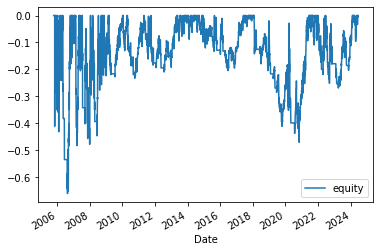

In [7]:
prices =series
ax = stats.prices.to_drawdown_series().plot()

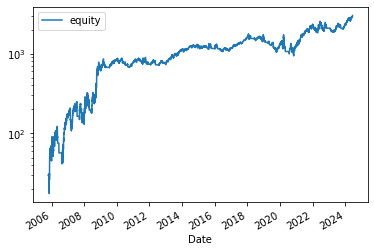

In [8]:
ax = prices.plot(logy=True)